In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install openpyxl==3.1.2

# Day 13 - MATH/PHYS 241

Sequences of data, either in space or in time, appear all the time in the measurements we make. Say we have a time series of measurements at a location (sediment trap data, ocean surface temperature, atmospheric gas concentration, etc.) that we would like to analyze. When we analyze the data, we can find long term linear trends (aka, secular trends) by applying a linear fit and finding the slope. Besides the longterm trend, we may also want to know interannual trends. These include things like seasonal influences on our variable that cause the plots to "oscilate".

Here, we will introduce one of the most common methods of signal processing: the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_analysis). Specifically, we will introduce the idea of what the Fourier Transform is, then the Discrete Fourier Transform, and finally, the Fast Fourier Transform.

As a side note, Fourier Analysis is a deep subject. By that, I mean there is [easily enough material to spend an entire](https://www.youtube.com/watch?v=gZNm7L96pfY&t=1s) year focusing only on applications of Fourier Transforms and their importance to things like signal processing. This notebook is a very brief overview of the topic. You will need to seek out other sources to gain a deeper understanding of the topic.  

# The Fourier Transform and Discrete Fourier Transform

Fourier transforms take us from "grid" space to "coefficient" space. Today, we will focus on a grid of *uniform samples in time*. The "coefficient" space becomes the frequency. Thus, the Fourier transform gives us a way of going from a signal evolving in time to a signal in terms of its frequencies.

The transform is given in the continuous case as:

$$
\begin{align}
F(\omega) = \frac{1}{\sqrt{2 \pi}} \int^{\infty}_{-\infty} f(t) e ^{-i \omega t} dt \tag{1}
\end{align}
$$

Equation 1 tells us we have some function $f(t)$ that evolves in time. To find $F$ as a function of frequencies $\omega$, we multiply the function by $e^{-i \omega t}$ then integrate over all time and multipy by $1/\sqrt{2\pi}$.

There is also an *Inverse Fourier Transform*, which takes a function in frequency space and tranforms it into time space:

$$
\begin{align}
f(t) = \frac{1}{\sqrt{2 \pi}} \int^{\infty}_{-\infty} F(\omega) e ^{i \omega t} dt \tag{2}
\end{align}
$$

Great, so how does this help us? We are unlikely to have a continuous function that describes what we are observing and we most definately won't have data that evolves over $- \infty$ to $\infty$.

Well, when we have signals of finite duration that are *sampled evenly in time*, we can use the [Discrete Fourier Transform](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform) (or DFT):

$$
\begin{align}
F_n &= \sum^{N-1}_{k=0} f_k e^{-2 \pi i k n / N} \tag{3}
\end{align}
$$

Where $f_k$ is the discrete time domain signal that represents our measurements. You might be wondering why the sum is only to $N-1$ instead of to $N$. This is because for the frequency domain, the thing that maters is the number of spacings between data points. If we have $N$ number of data, then we have $N-1$ number of spacings between data points.

We can recover the discrete data after we have tranformed the data by applying the *Inverse Discrete Fourier Transform*:

$$
\begin{align}
f_k = \frac{1}{N} \sum^{N-1}_{n=0} F_n e^{2 \pi i k n / N} \tag{4}
\end{align}
$$

*IMPORTANT*: The output of the DFT to a real signal input will be complex and have a real and an imaginary component.

To implement these functions in python:

In [152]:
def dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D array x.
    """
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))  # column vector
    W = np.exp(-2j * np.pi * k * n / N)  # DFT matrix
    return np.dot(W, x)

def idft(X):
    """
    Compute the Inverse Discrete Fourier Transform (IDFT) of a 1D array X.
    """
    X = np.asarray(X, dtype=complex)
    N = X.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))  # column vector
    W_inv = np.exp(2j * np.pi * k * n / N)  # IDFT matrix
    return np.dot(W_inv, X) / N

# Discrete Fourier Transform Example

Let's look at a very simple test signal to see how the DFT. Say we have a sine signal with an amplitue of 1 and a period of 20 seconds that we sampled every second, stating at $t_0 = 0$.

Text(0, 0.5, 'Amplitude')

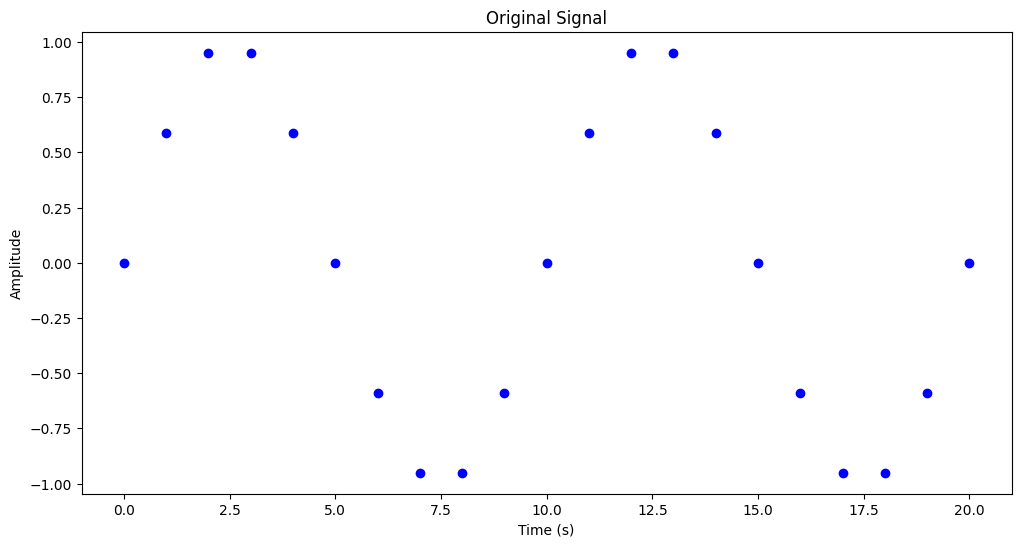

In [153]:
# Create a sample sine wave
dt = 1                                # time between samples (s)
sr = 1/dt                             # sampling rate (Hz)
t = np.arange(0, 21, sr)              # discrete time points
amplitude = 1
period = 10
f_k = amplitude * np.sin(2 * np.pi * t / period)

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.plot(t, f_k, 'bo')
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Now that we have our data, we can simply run it through our `dft` function to transform it.

In [154]:
# Run DFT
F_n = dft(f_k)

We are going to want to plot the newly transformed values, but what do we plot *against*? The DFT is computed from a signal that is sampled at some sample rate $f_s = 1/\Delta t$. Thus, the frequency bins are:

$$
\begin{align}
f_n &= \frac{n}{N \Delta t}, \ \ \text{for} \ n = 0, 1, 2, ..., N-1\tag{5}
\end{align}
$$

However, because the DFT is periodic and symmetric, the frequencies corresponding to indices greater than $N/2$ are interpreted as negative frequencies.

We can use the following function to calculate the binned frequencies for us.

In [155]:
def dft_frequencies(N, sr):
    dt = 1 / sr
    n = np.arange(N)
    return np.where(n < N // 2, n, n - N) / (N * dt)

Once we have the correct frequency bins to plot against, we can finally plot the transformed data.

In many cases, what we really want to do with the DFT is to create a [power spectral density](https://en.wikipedia.org/wiki/Spectral_density) plot. From this, it is easy to tell the distribution of power that is in the frequency components that compose the signal.

For real (non-imaginary) signal values, we can get the power by taking the absolute value of the DFT output and square it.

`power = np.abs(X) ** 2`

The last thing we need to do is scale the power so that the sum of all contributions matches the total power of the original signal.

`psd = power / (N**2 * dt)`

Where `dt` is the length of time between samples.

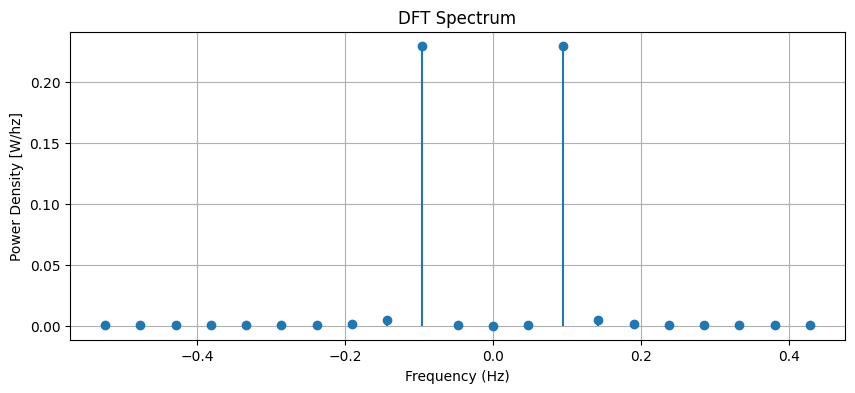

In [156]:
# Frequency bins for DFT output
N = len(F_n)
freqs = dft_frequencies(N, sr)   # frequencies in Hz (cycles/sec)

# Compute PSD
power = np.abs(F_n) ** 2
psd = power / (N**2 * dt)  # units: power per Hz

plt.figure(figsize=(10, 4))
plt.stem(freqs, psd, basefmt=" ")
plt.title('DFT Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Density [W/hz]')
plt.grid(True)
plt.show()

From the plot, we can see that the frequency with the highest magnitude is 0.1 Hz, which matches the frequency of the input signal.

Generally, we don't want to include the "-" frequencies as they are just a mirror of the "+". This can be done by changing the bounds of the plot.

Obviously this plot isn't particularly illuminating since we already knew the frequency of the signal was 0.1 Hz. However, where this method really shines is when we have a more complicated wave form.

## Class Problem 1

Upload the "Signal_Data.xlsx" file from CANVAS or my GitHub. The file contains generated discrete sample measurements of a signal composed of several different frequencies.

Use the Discrete Fourier Transform method to identify what frequencies make up the "observed" signal.

## Class Problem 2

Verify [Parsival's Theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem) that the Total Power of the signal in time space is equal to the total power of the signal in frequency space after taking the DFT.

To find the total power in time, we can use the following power equations:

`Total_Power_Time = np.sum(np.abs(amplitude)**2) * dt`

Where `amplitude` is the amplitude of the signal in time space and `dt` is the length of time between samples

`Total_Power_Freq = np.sum(psd) * sr`

Where `psd` is the Power Spectral Density of the signal and `sr` is the sample rate (or `1/dt`).

## Class Problem 3

The last thing we'd like to do is include a plot with the amplitude on the y-axis and the frequency on the x-axis. This will visually indicate what frequencies make up our noisy input signal as well as their individual amplitudes.

The amplitude of each frequency is obtained by taking the absolute value of the DFT output and multiplying by $2/N$, where $N$ is the length of the data.

# Fast Fourier Transform

In practice, we will not need to make our own DFT algorithm. [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html) already includes an excelent algorithm we may use:

`np.fft.fft()`

This computes the 1-dimensional discrete fourier transform for us. We can also have the function return the frequencies for us:

`np.fft.fftfreq()`



## Class Problem 4

Recreate the Amplitude vs Frequency plot, but use the FFT algorith with numpy to retrieve the Fourier Transform of the input data.